In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import random
from functools import partial
from contextlib import contextmanager
import matplotlib.pyplot as plt

DATA_DIR = '/media/elena/13e9efd4-799d-4087-8d03-b4e8eea4a3cc/MADE_DATA/2sem/AdvancedML/hw3_MCMC/corpora/'

random.seed(3)

 > В этом небольшом домашнем задании мы попробуем улучшить метод Шерлока Холмса. Как известно, в рассказе The Adventure of the Dancing Men великий сыщик расшифровал загадочные письмена... Пользовался он для этого так называемым частотным методом: смотрел, какие буквы чаще встречаются в зашифрованных текстах, и пытался подставить буквы в соответствии с частотной таблицей: E — самая частая и так далее.
В этом задании мы будем разрабатывать более современный и продвинутый вариант такого частотного метода. В качестве корпусов текстов для подсчётов частот можете взять что угодно, но для удобства вот вам “Война и мир” по-русски и по-английски.

 >   1. Реализуйте базовый частотный метод по Шерлоку Холмсу:
 
 >       ◦ подсчитайте частоты букв по корпусам (пунктуацию и капитализацию можно просто опустить, а вот пробелы лучше оставить);
        ◦ возьмите какие-нибудь тестовые тексты (нужно взять по меньшей мере 2-3 предложения, иначе вряд ли сработает), зашифруйте их посредством случайной перестановки символов;
        ◦ расшифруйте их таким частотным методом.

In [2]:
@contextmanager
def gen_file(filepath):
    f = open(filepath, 'r')
    try:
        yield (line for line in f)
    finally:
        f.close()

In [3]:
def count_letters(text_gen, letters):
    counts = Counter()
    for line in text_gen:
        counts.update(line.lower())
    counts = {s : counts[s] for s in letters}
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_counts

In [4]:
a = ord('а')
ru_letters = [chr(i) for i in range(a, a + 32)]
ru_letters.append(' ')
''.join(ru_letters)

'абвгдежзийклмнопрстуфхцчшщъыьэюя '

In [5]:
with gen_file(DATA_DIR + 'WarAndPeace.txt') as gen:
    ru_counts = count_letters(gen, ru_letters)
ru_counts[:5]

[(' ', 110708), ('о', 61282), ('а', 45209), ('е', 42519), ('и', 35838)]

In [6]:
def random_shift(letters):
    return random.sample(letters, k=len(letters))

Для тестирования возьмем несколько предложений из Википедии про Толстого и закодируем их.

In [7]:
cipher = random_shift(ru_letters)
true_encoder = dict(zip(ru_letters, cipher))
true_decoder = dict(zip(cipher, ru_letters))
#list(zip(true_encoder.items(), true_decoder.items()))

In [8]:
ru_text = "В своем дневнике Толстой сформулировал себе большое количество жизненных правил и целей, но удавалось следовать лишь их незначительной части. Среди удавшихся — серьезные занятия английским языком, музыкой, юриспруденцией. Кроме того, ни в дневнике, ни в письмах не отразилось начало занятия Толстым педагогикой и благотворительностью, хотя в 1849 году он впервые открыл школу для крестьянских детей. Основным преподавателем был Фока Демидович, крепостной, но и сам Лев Николаевич часто проводил занятия"

In [9]:
enc_text = ''.join([true_encoder[s] for s in ru_text.lower() if s in ru_letters])
enc_text

'люрлз яюус лсва ючзырчзьюршзхякывхзлпыюр и юизыщъз юазывм рчлзюфвтс ссцгюжхплвыювюн ы ьюсзюкуплпызрщюры узлпчщюывъщювгюс тспмвч ыщсзьюмпрчвюрх увюкуплъвгрдююр хщ тсц ютпсдчвдюпсэывьравяюдтцазяюяктцазьюйхвржхку снв ьюахзя ючзэзюсвюлюус лсва юсвюлюжврщяпгюс юзчхптвызрщюспмпызютпсдчвдючзырчцяюж упэзэвазьювюиыпэзчлзхвч ыщсзрчщйюгзчдюлююэзукюзсюлж хлц юзчахцыюъазыкюуыдюах рчщдсравгюу ч ьюзрсзлсцяюжх жзуплпч ы яюицыюшзапюу явузлвмюах жзрчсзьюсзювюрпяюы люсвазып лвмюмпрчзюжхзлзувыютпсдчвд'

Проверим, что зная истинный декодер мы можем правильно расшифровать текст:

In [10]:
''.join([true_decoder[s] for s in enc_text])

'в своем дневнике толстой сформулировал себе большое количество жизненных правил и целей но удавалось следовать лишь их незначительной части среди удавшихся  серьезные занятия английским языком музыкой юриспруденцией кроме того ни в дневнике ни в письмах не отразилось начало занятия толстым педагогикой и благотворительностью хотя в  году он впервые открыл школу для крестьянских детей основным преподавателем был фока демидович крепостной но и сам лев николаевич часто проводил занятия'

Частотный декодер строит соответствие между символами, упорядочивая их по частоте:

In [11]:
def freq_decoder(enc_text, lng_sorted_counts):
    enc_counts = Counter(enc_text)
    enc_counts = sorted(enc_counts.items(), key=lambda x: x[1], reverse=True)
    dec = {
        item[0] : lng_sorted_counts[i][0]
        for i, item in enumerate(enc_counts)
    } 
    return dec

In [12]:
def decoder_estimate(decoder, enc_text, true_decoder=None):
    if true_decoder:
        equal_items = decoder.items() & true_decoder.items()
        print(f"correct decoding: {len(equal_items)} letters: ")
        print(list(zip(*equal_items))[1])
    print(''.join([decoder[c] for c in enc_text]))

In [13]:
ru_freq_dec = freq_decoder(enc_text, ru_counts)
decoder_estimate(ru_freq_dec, enc_text, true_decoder)

correct decoding: 7 letters: 
('м', 'о', 'с', 'р', 'в', ' ', 'ш')
в своам киавиеда лонслоя схормзнеровтн сажа жонушоа донебаслво эегиаииьч ыртвен е юаная ио зктвтносу снаковтлу нешу еч иагитбелануиоя бтсле сраке зктвшечсп  саруагиьа гтиплеп тийнеясдем пгьдом мзгьдоя цресырзкаиюеая дрома лойо ие в киавиеда ие в ыесумтч иа олртгеносу итбтно гтиплеп лонсльм ыактйойедоя е жнтйолворелануиослуц чолп в  йокз ои выарвьа олдрьн шдонз кнп драслуписдеч калая осиовиьм ыраыоктвтланам жьн ходт камековеб драыослиоя ио е стм нав иедонтавеб бтсло ыровокен гтиплеп


Частотным методом удалось расшифровать пробел и 6 букв, но этого явно недотаточно для понимания текста.

>    2. Вряд ли в результате получилась такая уж хорошая расшифровка, разве что если вы брали в качестве тестовых данных целые рассказы. Но и Шерлок Холмс был не так уж прост: после буквы E, которая действительно выделяется частотой, дальше он анализировал уже конкретные слова и пытался угадать, какими они могли бы быть. Я не знаю, как запрограммировать такой интуитивный анализ, так что давайте просто сделаем следующий логический шаг:

>        ◦ подсчитайте частоты биграмм (т.е. пар последовательных букв) по корпусам;
        ◦ проведите тестирование аналогично п.1, но при помощи биграмм

In [14]:
def count_bigrams(text_gen, letters):
    counts = Counter()
    for line in text_gen:
        text = line.lower()
        text = ''.join([s for s in text if s in letters])
        counts.update(zip(text[:-1], text[1:]))
            
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_counts

In [15]:
with gen_file(DATA_DIR + 'WarAndPeace.txt') as gen:
    ru_bigrams = count_bigrams(gen, ru_letters)
ru_bigrams[:5]

[(('о', ' '), 13071),
 (('и', ' '), 11180),
 (('а', ' '), 10194),
 (('е', ' '), 9799),
 ((' ', 'с'), 9798)]

In [16]:
len(ru_bigrams)

787

In [17]:
enc_bigrams = count_bigrams((enc_text,), ru_letters)
len(enc_bigrams)

208

Биграмм всего может быть 33*33, т.е. каждый символ с каждым. Для удобства представим их в виде датафрейма, упорядочим строки и столбцы по частоте из п.1.

In [18]:
def bigram_to_df(bigrams, letters):
    bigram_df = pd.DataFrame(0, columns=letters, index=letters)
    for (s1, s2), n in bigrams:
        bigram_df.loc[s1, s2] = n
    return bigram_df

In [19]:
ru_labels = list(list(zip(*ru_counts))[0])
ru_bigram_df = bigram_to_df(ru_bigrams, ru_labels)
ru_bigram_df.head(5)

,,о,а,е,и,н,т,с,л,в,...,й,ж,ш,х,ю,ц,э,щ,ф,ъ
,8592,7542,1848,2435,6739,9223,4298,9798,1666,9458,...,17,1062,625,715,40,189,1566,47,492,1
о,13071,121,5,1347,500,4284,4281,4156,4316,5132,...,2296,1018,826,346,470,59,14,80,299,0
а,10194,4,10,549,78,3275,2992,2390,5673,2191,...,487,764,623,621,497,56,1,151,325,0
е,9799,157,6,924,104,4294,2281,2200,3804,847,...,1467,597,460,661,220,173,0,413,9,0
и,11180,173,45,1496,402,2040,2111,1784,3137,1659,...,907,247,227,1071,185,908,1,67,11,0


В итоге нам надо найти порядок символов (строк и столбцов), как упорядочить табличку с биграммами не очень понятно, так что попробуем из нее извлечь некоторые эмбеддинги для отдельных символов. Т.е. помимо частоты символов еще посчитаем их скалярное произведение с соседними символами. Декодер будет подбирать для каждого символа наиболее близкий по эмбеддингу символ.

In [20]:
def bigram_embeddings(bigram_df):
    emb = pd.DataFrame(0, columns = bigram_df.columns, index=[0,1,2,3])
    for c in bigram_df.columns:
        emb.loc[0, c] = (bigram_df.loc[c].values * 
                         bigram_df[c].values).sum()
        emb.loc[1, c] = (bigram_df[c] * 
                        bigram_df[c]).sum() / \
                        (bigram_df * 
                        bigram_df[c].values[:,np.newaxis]).sum().sum()
        emb.loc[2, c] = (bigram_df.loc[c] * 
                        bigram_df.loc[c]).sum() / \
                        (bigram_df * 
                        bigram_df.loc[c]).sum().sum()
        emb.loc[3, c] = bigram_df[c].sum()
    emb.loc[0] /= emb.loc[0].sum()
    emb.loc[3] /= bigram_df.sum().sum()
    emb = emb.fillna(0)
    return emb

def bigram_decoder(lng_emb1, msg_emb):
    lng_emb = lng_emb1.copy()
    msg_labels = (msg_emb * msg_emb).sum(axis=0).sort_values(ascending=False).index.tolist()
    dec = {}
    for msg_c in msg_labels:
        similarity = (lng_emb * msg_emb[msg_c].values[:,np.newaxis]).sum(axis=0)
        lng_c = similarity.idxmax()
        del lng_emb[lng_c]
        dec[msg_c] = lng_c
    return dec

In [21]:
ru_emb = bigram_embeddings(ru_bigram_df)
ru_emb

,,о,а,е,и,н,т,с,л,в,...,й,ж,ш,х,ю,ц,э,щ,ф,ъ
0,0.271738,0.156977,0.073991,0.060123,0.069582,0.064251,0.045323,0.027775,0.043951,0.045463,...,0.000065,0.001487,0.001084,0.001428,0.000076,0.000191,0.000030,0.000229,0.000068,5.905258e-10
1,0.202810,0.159163,0.147092,0.090782,0.081438,0.077327,0.082788,0.076276,0.076838,0.077193,...,0.034977,0.014486,0.012978,0.014112,0.012203,0.012101,0.014022,0.007063,0.004888,7.433030e-03
2,0.205809,0.132897,0.105251,0.099675,0.093321,0.096175,0.089460,0.084786,0.066432,0.057233,...,0.041105,0.035001,0.023564,0.018264,0.018197,0.008904,0.038023,0.013381,0.006162,4.774473e-03
3,0.168659,0.094596,0.069895,0.065773,0.055301,0.054143,0.047319,0.043418,0.042174,0.038169,...,0.009608,0.008440,0.007867,0.007108,0.005406,0.003370,0.002503,0.002342,0.001861,4.378500e-04


In [22]:
enc_df = bigram_to_df(enc_bigrams, ru_labels)
enc_emb = bigram_embeddings(enc_df)

bigram_dec = bigram_decoder(ru_emb, enc_emb)
decoder_estimate(bigram_dec, enc_text, true_decoder)

correct decoding: 9 letters: 
('о', 'т', 'л', 'ю', 'ъ', 'в', ' ', 'и', 'ш')
в евоад ясавсира толетоь ежопдблиповнл еаэа эолкшоа ролийаетво щимсассгч ыпнвил и халаь со бянвнлоек елаяовнтк лишк ич самснйиталксоь йнети епаяи бянвшичеу  еапкамсга мнсутиу нсзлиьерид умгрод дбмгроь юпиеыпбяасхиаь рпода тозо си в ясавсира си в ыиекднч са отпнмилоек снйнло мнсутиу толетгд ыаянзозироь и элнзотвопиталксоеткю чоту в  зояб ос выапвга отрпгл шролб ялу рпаеткусерич яатаь оесовсгд ыпаыоянвнталад эгл жорн яадияовий рпаыоетсоь со и енд лав сиролнавий йнето ыповояил мнсутиу


<ipython-input-20-75d67f1ef0b6>:6: RuntimeWarning: invalid value encountered in long_scalars
  emb.loc[1, c] = (bigram_df[c] *
<ipython-input-20-75d67f1ef0b6>:10: RuntimeWarning: invalid value encountered in long_scalars
  emb.loc[2, c] = (bigram_df.loc[c] *


Получилось не намного лучше частотного метода.

> 3. Но и это ещё не всё: биграммы скорее всего тоже далеко не всегда работают. Основная часть задания — в том, как можно их улучшить:

>         ◦ предложите метод обучения перестановки символов в этом задании, основанный на MCMC-сэмплировании, но по-прежнему работающий на основе статистики биграмм;
        ◦ реализуйте и протестируйте его, убедитесь, что результаты улучшились.

Хотелось бы так переставить столбцы и строки матрицы биграмм закодированного текста, чтобы они максимально соответствовали частотам биграмм русских слов. Т.е. если вероятности биграмм в Войне и Мире обозначить $P_{ij}$, а количество биграмм в зашированной строке $n_{ij}$, то мы хотим максимизировать правдоподобие $$ \Pi P_{ij}^{n_{ij}} \to max$$

или логарифм правдоподобия $$ \sum n_{ij}log(P_{ij}) \to max $$

Будем использовать MCMC-сэмплирование для перестановки $n_{ij}$ так, чтобы увеличивать правдоподобие

Найдем логарифм вероятностей для биграмм корпуса:

In [23]:
ru_logits_df = np.log(ru_bigram_df.replace(0, 0.1)) - \
               np.log(ru_bigram_df.sum().sum()) 
ru_logits_df.head(5)

,,о,а,е,и,н,т,с,л,в,...,й,ж,ш,х,ю,ц,э,щ,ф,ъ
,-4.320494,-4.450838,-5.857222,-5.581379,-4.563414,-4.249625,-5.013176,-4.189147,-5.960900,-4.224465,...,-10.545868,-6.411172,-6.941329,-6.806798,-9.690202,-8.137334,-6.022801,-9.528933,-7.180602,-13.379081
о,-3.900930,-8.583290,-11.769643,-6.173446,-7.164473,-5.016439,-5.017139,-5.046773,-5.008997,-4.835830,...,-5.640157,-6.453486,-6.662486,-7.532642,-7.226348,-9.301544,-10.740024,-8.997054,-7.678637,-15.681666
а,-4.149526,-11.992787,-11.076496,-7.070983,-9.022372,-5.285008,-5.375384,-5.600032,-4.735608,-5.686968,...,-7.190817,-6.740513,-6.944534,-6.947750,-7.170491,-9.353729,-13.379081,-8.361801,-7.595256,-15.681666
е,-4.189045,-8.322835,-11.587321,-6.550369,-8.734690,-5.014107,-5.646712,-5.682868,-5.135273,-6.637380,...,-6.088106,-6.987164,-7.247854,-6.885327,-7.985453,-8.225789,-15.681666,-7.355633,-11.181856,-15.681666
и,-4.057199,-8.225789,-9.572418,-6.068531,-7.382629,-5.758376,-5.724164,-5.892468,-5.328059,-5.965111,...,-6.568939,-7.869693,-7.954131,-6.402733,-8.158725,-6.567837,-13.379081,-9.174388,-10.981186,-15.681666


Упорядочим символы зашифрованной строки по частоте (начальное приближение) и найдем датафрейм с количеством биграмм.

In [24]:
enc_labels = list(list(zip(*count_letters((enc_text), ru_letters)))[0])
enc_bigram_df = bigram_to_df(enc_bigrams, enc_labels)
enc_bigram_df.head()

,ю,з,,в,с,ы,п,р,ч,л,...,э,и,ъ,й,н,ш,ф,б,е,о
ю,2,4,0,4,8,2,1,7,3,4,...,1,3,1,1,1,1,1,0,0,0
з,6,0,2,0,1,6,0,5,4,5,...,2,0,0,0,0,0,0,0,0,0
,8,0,0,0,2,4,0,2,1,4,...,0,1,0,0,0,0,0,0,0,0
в,7,0,1,0,0,3,0,2,2,0,...,0,0,1,0,0,0,0,0,0,0
с,1,6,5,5,1,0,2,1,0,0,...,1,0,0,0,1,0,0,0,0,0


Семплировать будем перестановкой двух символов в текущем шифре. Запоминаем шифр с максимальным правдоподобием

In [25]:
def bigram_log_likelihood(cipher, logits_df, enc_bigram_df):
    df = logits_df.values * enc_bigram_df.loc[cipher, cipher].values
    return df.sum().sum()

def cipher_sample(cipher1):
    cipher = cipher1.copy()
    first_idx = random.randrange(len(cipher))
#     second_idx = random.randrange(len(cipher))
#     if first_idx == second_idx:
#         return cipher_sample(cipher)
    offset = 0
    while offset == 0:
        offset = round(np.random.normal(0, 5))
    second_idx = first_idx + offset
    if second_idx < 0 or second_idx >= len(cipher):
        return cipher_sample(cipher)
    cipher[first_idx], cipher[second_idx] = cipher[second_idx], cipher[first_idx]
    return cipher
    
def metropolis_hastings_log_accept(l, l_new):
    if l_new > l:
        return True
    else:
        return (np.random.rand() < (np.exp(l_new - l)))

def metropolis_hastings(func_log_likelihood, 
                        init_cipher,
                        iter_n):
    cur_cipher = init_cipher.copy()
    cur_llh = func_log_likelihood(cur_cipher)
    best_cipher, best_llh = cur_cipher.copy(), cur_llh
    samples_llh, accept_bit = [cur_llh], [1]
    for i in range(iter_n):
        new_cipher = cipher_sample(cur_cipher)
        new_llh = func_log_likelihood(new_cipher)
        samples_llh.append(new_llh)
        if new_llh > best_llh:
            best_llh = new_llh
            best_cipher = new_cipher.copy()
        if (metropolis_hastings_log_accept(cur_llh, new_llh)):
            cur_cipher, cur_llh = new_cipher, new_llh
            accept_bit.append(1)
        else:
            accept_bit.append(0)

    samples_llh = np.array(samples_llh)
    accept_bit = np.array(accept_bit)
       
#     x = np.arange(len(samples_llh))
#     mask = accept_bit > 0
#     plt.clf()
#     plt.plot(x, samples_llh, 'y.', x[mask], samples_llh[mask], 'b.')
    
    return best_llh, best_cipher, samples_llh, accept_bit

log_likelihood = -2731.622513377; accept = 0.0285; correct 27 letters
log_likelihood = -2731.622513377; accept = 0.0262; correct 28 letters
log_likelihood = -2731.622513377; accept = 0.0230; correct 28 letters
log_likelihood = -2731.622513377; accept = 0.0227; correct 28 letters
log_likelihood = -2731.622513377; accept = 0.0251; correct 28 letters
log_likelihood = -2769.116243582; accept = 0.0231; correct 25 letters
log_likelihood = -2731.622513377; accept = 0.0225; correct 27 letters
log_likelihood = -2731.622513377; accept = 0.0260; correct 28 letters
log_likelihood = -2731.622513377; accept = 0.0267; correct 28 letters
log_likelihood = -2731.622513377; accept = 0.0247; correct 27 letters


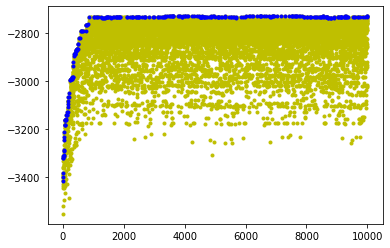

In [26]:
ru_log_likelihood = partial(bigram_log_likelihood,
                         logits_df = ru_logits_df,
                         enc_bigram_df = enc_bigram_df)

best_cipher = enc_labels
best_llh = ru_log_likelihood(best_cipher)
best_samples_llh, best_accept_bit = [], []
for _ in range(10):
    llh, cipher, samples_llh, accept_bit = \
        metropolis_hastings(ru_log_likelihood,
                            init_cipher=enc_labels,#random_shift(ru_letters),
                            iter_n=10000)
   
    if best_llh < llh:
        best_llh = llh
        best_cipher = cipher
        best_samples_llh = samples_llh
        best_accept_bit = accept_bit
        
    dec = {
        cipher[i] : ru_labels[i]
        for i in range(len(cipher))
    }
    equals_items = dec.items() & true_decoder.items()
    print(f"log_likelihood = {llh:.9f}; "
          f"accept = {accept_bit.sum() / accept_bit.size:.4f}; "
          f"correct {len(equals_items)} letters")
    
x = np.arange(len(best_samples_llh))
mask = best_accept_bit > 0
plt.plot(x, best_samples_llh, 'y.', x[mask], best_samples_llh[mask], 'b.')    

In [27]:
ru_bigram_dec = {
    best_cipher[i] : ru_labels[i]
    for i in range(len(best_cipher))
}
decoder_estimate(ru_bigram_dec, enc_text, true_decoder)

correct decoding: 27 letters: 
('м', 'о', 'л', 'й', 'х', ' ', 'я', 'б', 'з', 'с', 'ю', 'д', 'ч', 'г', 'н', 'т', 'р', 'а', 'в', 'и', 'у', 'ш', 'к', 'ь', 'ы', 'п', 'е')
в своем дневнике толстой сцормулировал себе большое количество физненных правил и желей но удавалось следовать лишь их незначительной части среди удавшихся  серьезные занятия английским языком музыкой юриспруденжией кроме того ни в дневнике ни в письмах не отразилось начало занятия толстым педагогикой и благотворительностью хотя в  году он впервые открыл школу для крестьянских детей основным преподавателем был цока демидович крепостной но и сам лев николаевич часто проводил занятия


Семплирование рулит! Почти все символы разгаданы, расшифрованный текст легко читается.

   > 4. Расшифруйте сообщение:
←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏

In [28]:
enc_message = "←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏"
enc_message

'←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏'

In [29]:
enc_letters = list(set(enc_message))
print(enc_letters)
print(len(enc_letters))

['↹', '⇈', '↷', '⇛', '←', '↝', '↤', '⇒', '↘', '⇯', '⇆', '⇏', '⇷', '⇴', '↙', '↾', '↞', '⇰', '⇠', '⇞', '↳', '↟', '⇙', '⇸', '⇊', '↲', '⇌', '↨']
28


In [30]:
message_bigram = count_bigrams((enc_message,), enc_letters)

Считаем, что сообщение на русском языке, так что дополняем недостающие символы до полного комплекта и строим датафрейм биграмм (опять упорядочиваем символы по частоте, чтобы лучше считалось).

In [31]:
enc_labels = list(list(zip(*count_letters((enc_message), enc_letters)))[0])
enc_labels = enc_letters + ['1', '2', '3', '4', '5']

message_df = bigram_to_df(message_bigram, enc_labels)
message_df.head()

,↹,⇈,↷,⇛,←,↝,↤,⇒,↘,⇯,...,⇸,⇊,↲,⇌,↨,1,2,3,4,5
↹,0,0,5,1,0,4,0,1,1,0,...,1,0,1,3,1,0,0,0,0,0
⇈,1,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
↷,0,0,0,0,1,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
⇛,6,0,0,1,1,1,0,1,0,4,...,0,0,2,0,2,0,0,0,0,0
←,8,0,0,0,2,1,1,1,0,1,...,0,0,0,1,1,0,0,0,0,0


log_likelihood = -1257.218078704; accept = 0.0664; 
log_likelihood = -1277.031003624; accept = 0.0673; 
log_likelihood = -1291.932101919; accept = 0.0780; 
log_likelihood = -1256.524899965; accept = 0.0732; 
log_likelihood = -1280.881251144; accept = 0.0746; 
log_likelihood = -1396.830760137; accept = 0.0673; 
log_likelihood = -1277.145865806; accept = 0.0713; 
log_likelihood = -1390.304582139; accept = 0.0667; 
log_likelihood = -1255.920937987; accept = 0.0734; 
log_likelihood = -1385.697127346; accept = 0.0634; 

если вы вимите норжальный или подти норжальный текст у этого соочшения который легко продитать скорее всего вы все смелали правильно и полудите жаксижальный чалл за послемнее детвертое замание курса ботя конедно я нидего не очешах


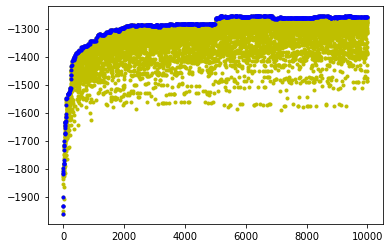

In [32]:
log_likelihood = partial(bigram_log_likelihood,
                         logits_df = ru_logits_df,
                         enc_bigram_df = message_df)
best_cipher = enc_labels
best_llh = log_likelihood(best_cipher)
best_samples_llh, best_accept_bit = [], []
for _ in range(10):
    llh, cipher, samples_llh, accept_bit = \
        metropolis_hastings(log_likelihood,
                            init_cipher=enc_labels,
                            iter_n=10000)
    if best_llh < llh:
        best_llh = llh
        best_cipher = cipher
        best_samples_llh = samples_llh
        best_accept_bit = accept_bit
        
    dec = {
        cipher[i] : ru_labels[i]
        for i in range(len(cipher))
    }

    print(f"log_likelihood = {llh:.9f}; "
          f"accept = {accept_bit.sum() / accept_bit.size:.4f}; ")
    
x = np.arange(len(best_samples_llh))
mask = best_accept_bit > 0
plt.plot(x, best_samples_llh, 'y.', x[mask], best_samples_llh[mask], 'b.')    
        
message_dec = {
    best_cipher[i] : ru_labels[i]
    for i in range(len(best_cipher))
}
print('')
decoder_estimate(message_dec, enc_message)

Получилась не идеальная, но вполне читаемая расшифровка. Как такое можно получить без MCMC-сэмплирования даже не представляю!

> Бонус: а что если от биграмм перейти к триграммам (тройкам букв) или даже больше? Улучшатся ли результаты? Когда улучшатся, а когда нет? Чтобы ответить на этот вопрос эмпирически, уже может понадобиться погенерировать много тестовых перестановок и последить за метриками, глазами может быть и не видно.

Тут с биграммами то не знаешь, что делать, а уж про триграммы и думать страшно;) Разве что как-то ограничить набор триграмм самыми частыми.

> Бонус: какие вы можете придумать применения для этой модели? Пляшущие человечки ведь не так часто встречаются в жизни (хотя встречаются! и это самое потрясающее во всей этой истории, но об этом я расскажу потом).

Да тут применений дофига, в любой задаче планирования, комбинаторной оптимизации, и везде где непонятно как подступиться, кроме как перебором или придумыванием каких-то эвристик. Для меня это просто открытие! Оказывается достаточно посемплировать - и уже получишь более чем приемлемое решение.